# Web traffic 분석

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

## 데이터 불러오기 & 탐색

In [5]:
df = pd.read_csv('./data/api_data.csv')
df = df.drop(['browser_version', 'os_version', 'browser_family','is_mobile','utm_content', 'utm_term', 'user', 'referrer_host', 'full_url',
          'is_tablet', 'is_pc', 'is_touch_capable', 'device_family', 'os_family', 'search_query', 'search_engine', 'user_agent'], axis=1)

In [6]:
df['visited_at'] = pd.to_datetime(df['visited_at'], format='ISO8601')
df['date'] = df['visited_at'].dt.date
df['hour'] = df['visited_at'].dt.hour # 향후 제거할 수 있음.

In [7]:
def view_plot(col, top_n=15):
    """상위 항목의 일별 추이 시각화"""

    top_values = df[col].value_counts().head(top_n).index
    actual_n = len(top_values)
    
    daily_counts = df[df[col].isin(top_values)].groupby(['date', col]).size().unstack(fill_value=0)
    
    # 시각화
    daily_counts.plot(figsize=(14, 6), marker='o')
    plt.title(f'Daily {col} Views - Top {actual_n}')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.legend(title=col, bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

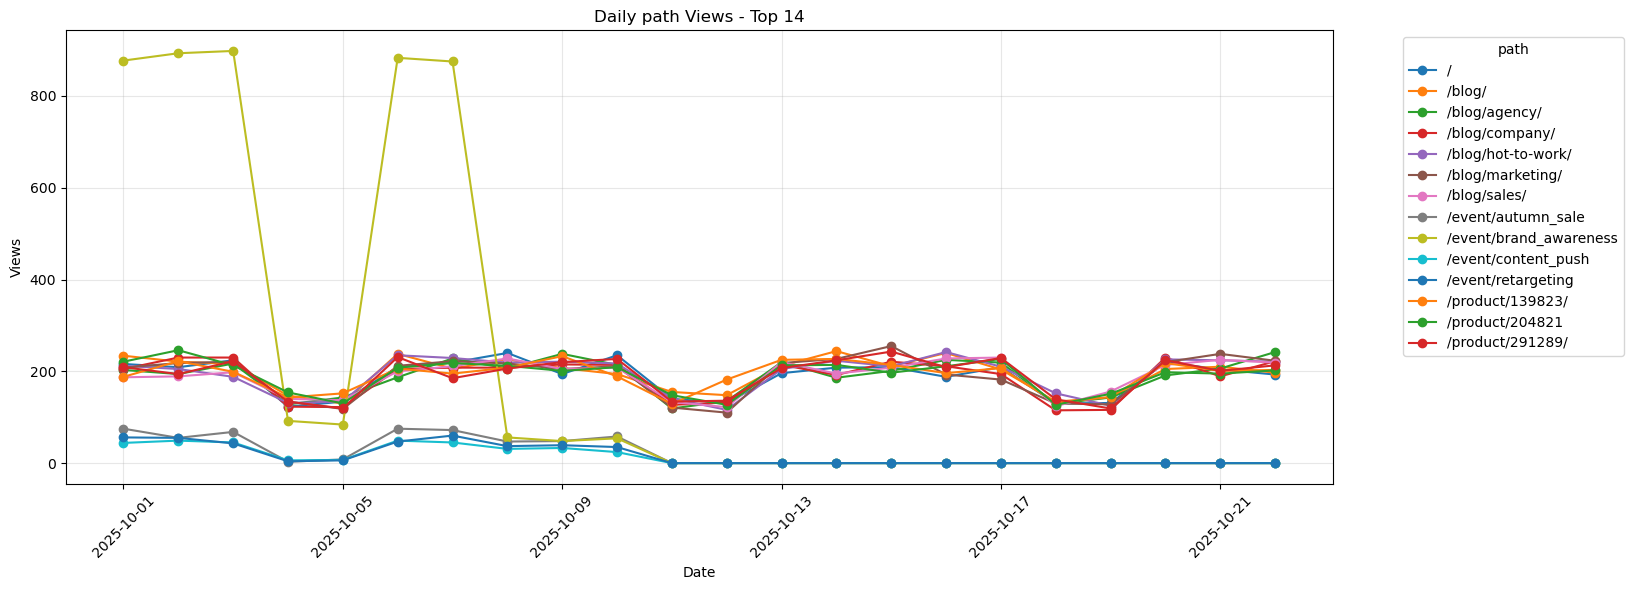

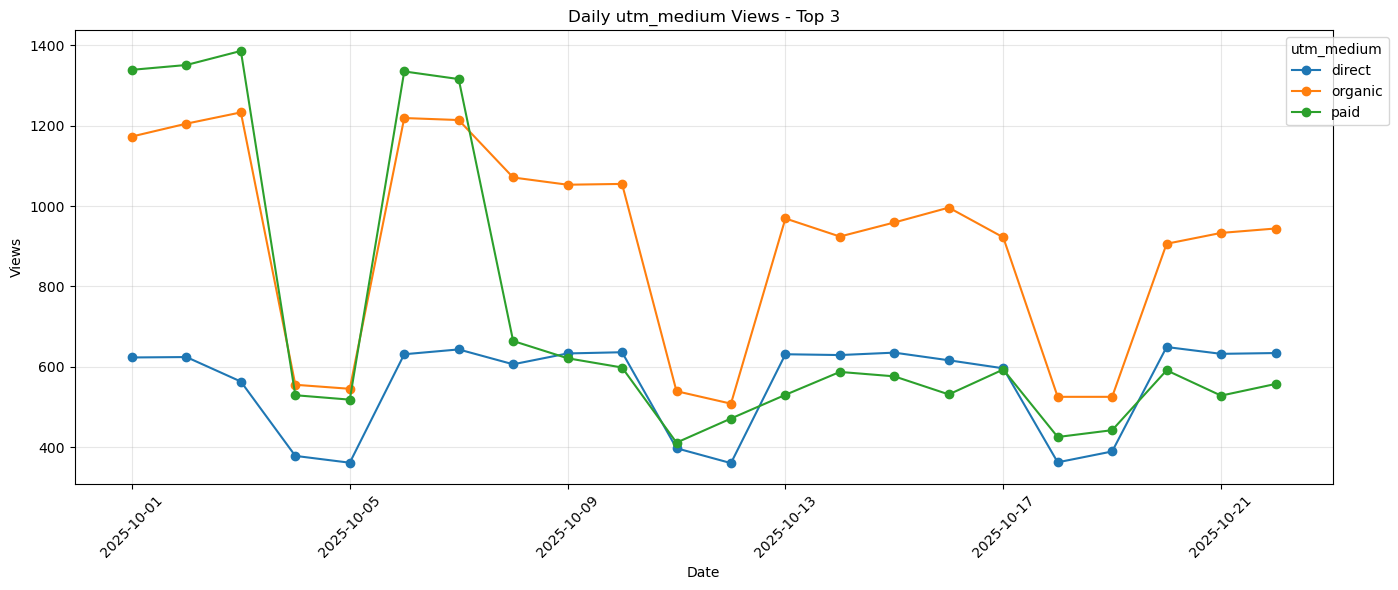

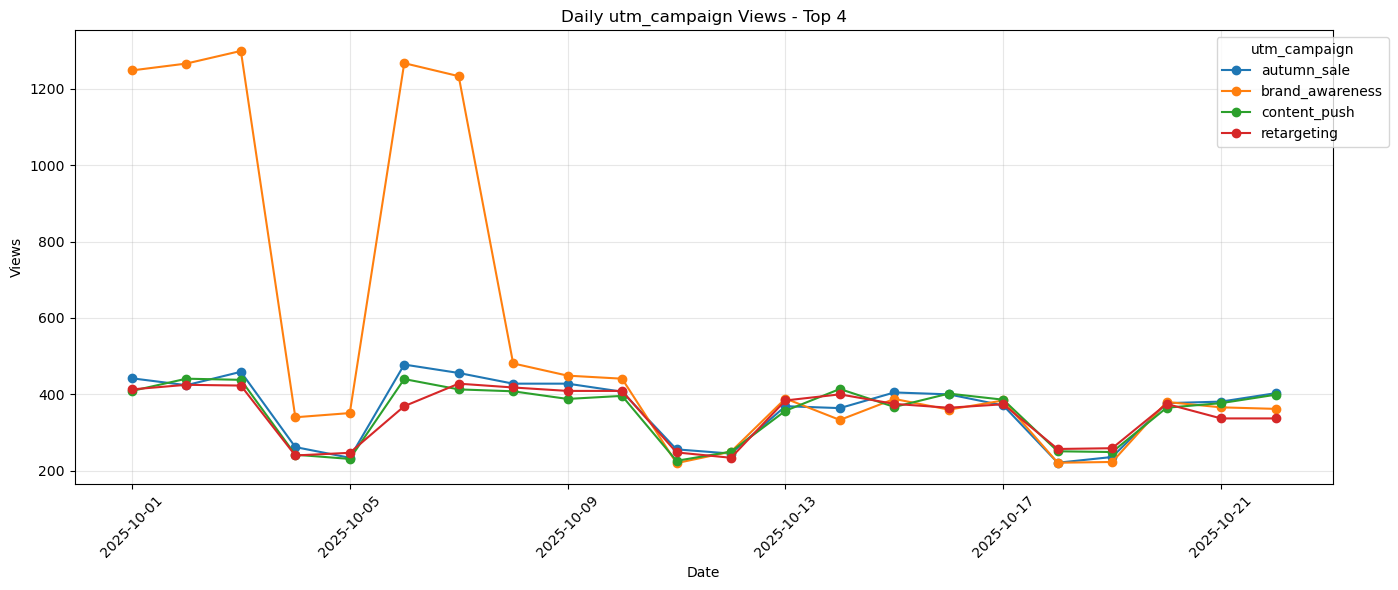

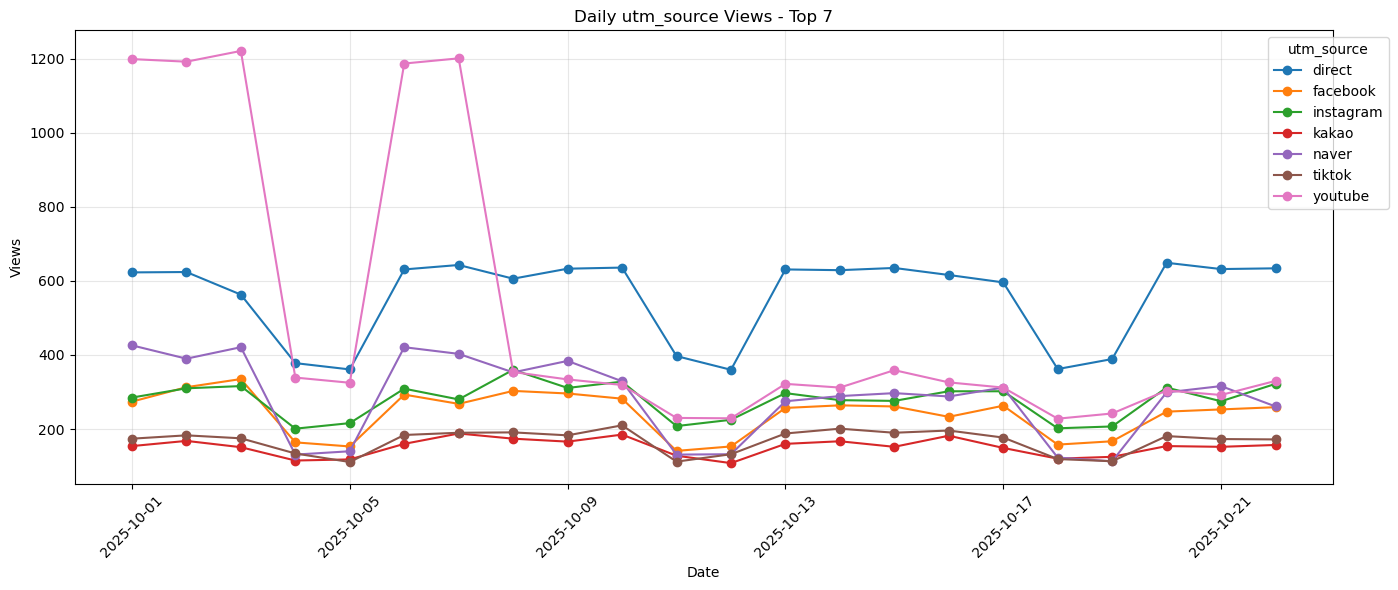

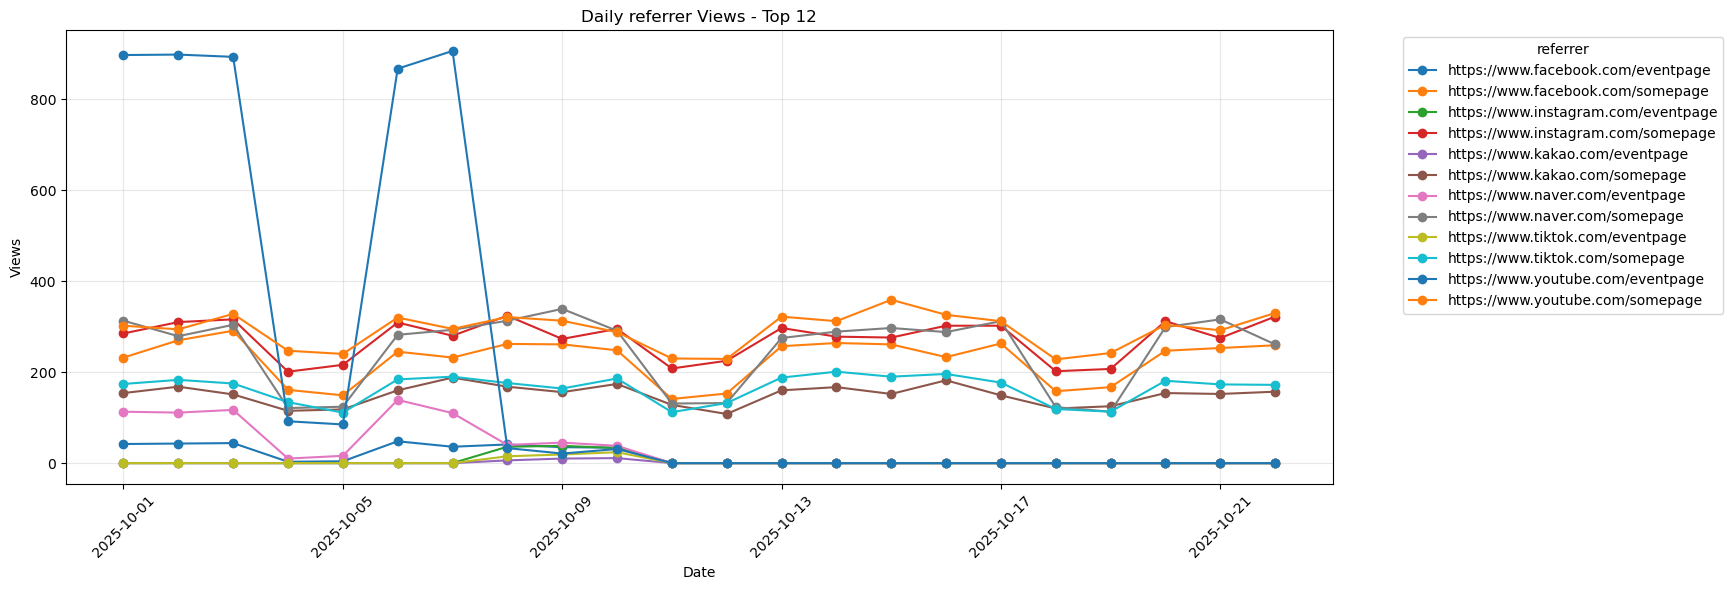

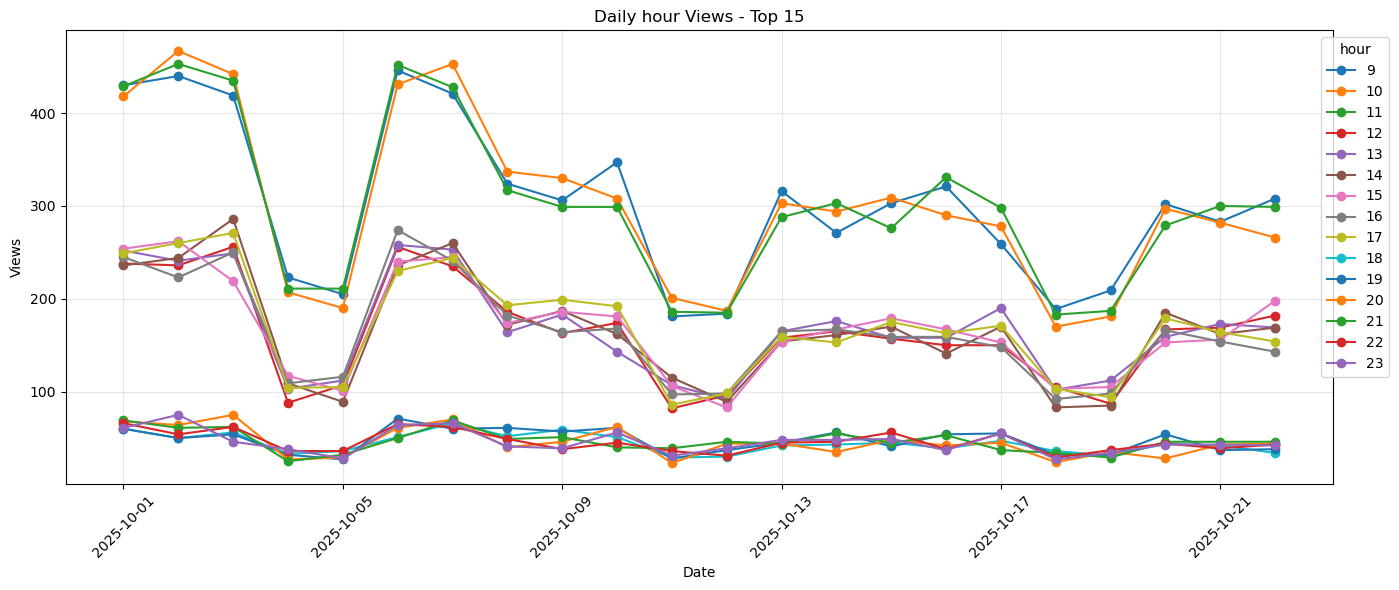

In [8]:
view_plot('path')
view_plot('utm_medium')
view_plot('utm_campaign')
view_plot('utm_source')
view_plot('referrer')
view_plot('hour')

### 주기성 확인

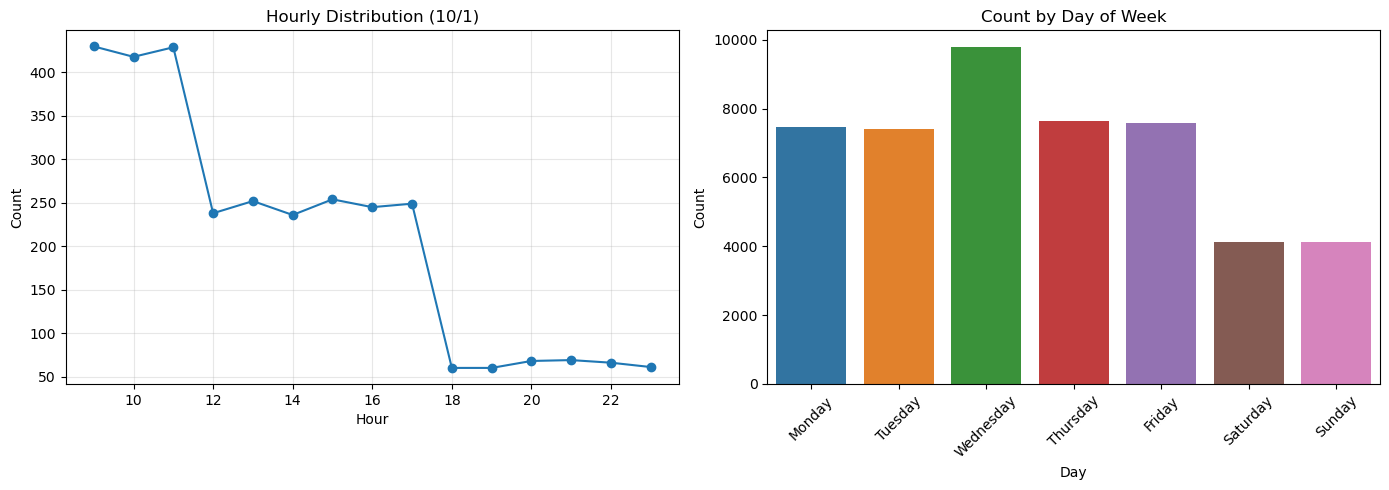

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 왼쪽: 하루 시간대별
df[df['date'] == df['date'][0]]['hour'].value_counts().sort_index().plot(kind='line', ax=axes[0], marker='o')
axes[0].set_title('Hourly Distribution (10/1)')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# 오른쪽: 요일별
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['dayofweek'] = pd.to_datetime(df['date']).dt.day_name()
day_counts = df['dayofweek'].value_counts().reindex(day_order)

sns.barplot(x=day_counts.index, y=day_counts.values, hue=day_counts.index, legend=False, ax=axes[1])
axes[1].set_title('Count by Day of Week')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- 하루중 아침 > 점심 > 저녁 순으로 극명하게 사용자가 갈립니다.
- 토,일 40%정도 적고, 수요일 20%정도 많음.

#### Ip 주소

In [10]:
import geoip2.database

reader = geoip2.database.Reader('./data/GeoLite2-City.mmdb') # 홈페이지에서 다운 받아야 사용 가능

def get_location(ip):
    try:
        response = reader.city(ip)
        return {
            'country': response.country.name,
            'city': response.city.name
        }
    except:
        return {'country': None, 'city': None}

df['location'] = df['ip_address'].apply(get_location)
df['country'] = df['location'].apply(lambda x: x['country'])
df['city'] = df['location'].apply(lambda x: x['city'])
df = df.drop(['location', 'ip_address'], axis=1) 

### 추가 조사

**path 세분화**

In [11]:
df['path_category'] = np.select(
    [
        df['path'] == '/',
        df['path'].str.startswith('/blog', na=False),
        df['path'].str.startswith('/event', na=False),
        df['path'].str.startswith('/product', na=False)
    ],
    ['home', 'blog', 'event', 'product'],
    default='other'
)

**referrer 세분화**

In [12]:
df['referrer_type'] = np.select(
    [
        df['referrer'].isna(),
        df['referrer'].str.contains('somepage', na=False),
        df['referrer'].str.contains('eventpage', na=False)
    ],
    ['direct', 'somepage', 'eventpage'],
    default='other'
)

In [13]:
def extract_source(referrer):
    """referrer source 추출"""
    """ex)www.instagram.com->instagram"""
    if pd.isna(referrer):
        return 'direct'
    try:
        parts = referrer.split('//')[1].split('.')[1]
        return parts
    except:
        return 'other'

df['referrer_source'] = df['referrer'].apply(extract_source)

#### eventpage vs somepage

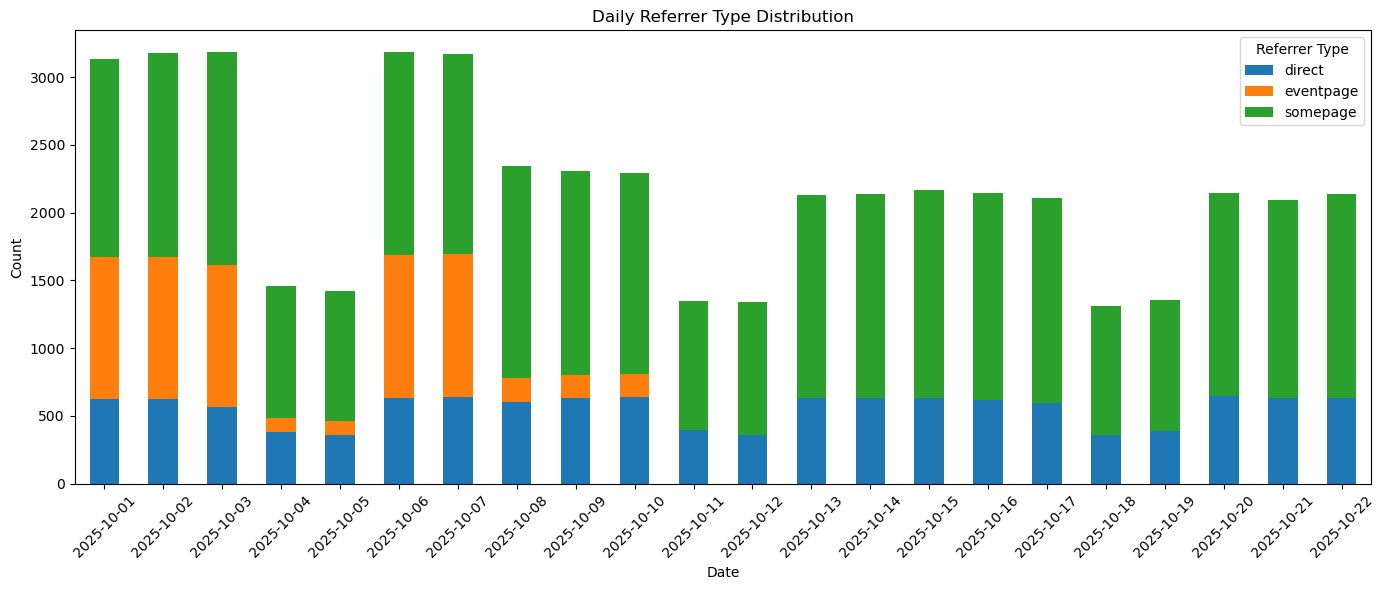

In [14]:
df.groupby(['date', 'referrer_type']).size().unstack(fill_value=0).plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Daily Referrer Type Distribution')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Referrer Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

10/11 기점으로 `event_page`가 없는 것으로 보아, 광고가 중단된 것으로 보인다.  
event_page가 있는 그룹을 campaign, 없는 그룹을 post campaign이라 하고,  
11일 경계로 campaign 그룹, post campaign 그룹으로 나누어 광고 효과를 비교해보면 어떨까?  

## 광고 효과 분석

In [15]:
df['period'] = df['date'].apply(lambda x: 'campaign' if x <= date(2025, 10, 10) else 'post_campaign')

# 일별 세션 수
daily_sessions = df.groupby(['period', 'date'])['session_key'].nunique().reset_index()
daily_sessions.columns = ['period', 'date', 'sessions']

campaign_daily = daily_sessions[daily_sessions['period']=='campaign']['sessions']
post_daily = daily_sessions[daily_sessions['period']=='post_campaign']['sessions']

In [16]:
# 기간별 주요 지표
summary = pd.DataFrame({
    'Total Sessions': df.groupby('period')['session_key'].nunique(),
    'Total Logs': df.groupby('period').size(),
    'Paid': df[df['utm_medium']=='paid'].groupby('period').size(),
    'Organic': df[df['utm_medium']=='organic'].groupby('period').size(),
    'Direct': df[df['utm_medium']=='direct'].groupby('period').size(),
    'Autumn Sale': df[df['utm_campaign']=='autumn_sale'].groupby('period').size(),
    'Product Views': df[df['path_category']=='product'].groupby('period').size(),
})

summary['Paid %'] = (summary['Paid'] / summary['Total Logs'] * 100).round(2)
summary['Product %'] = (summary['Product Views'] / summary['Total Logs'] * 100).round(2)

**시각화**

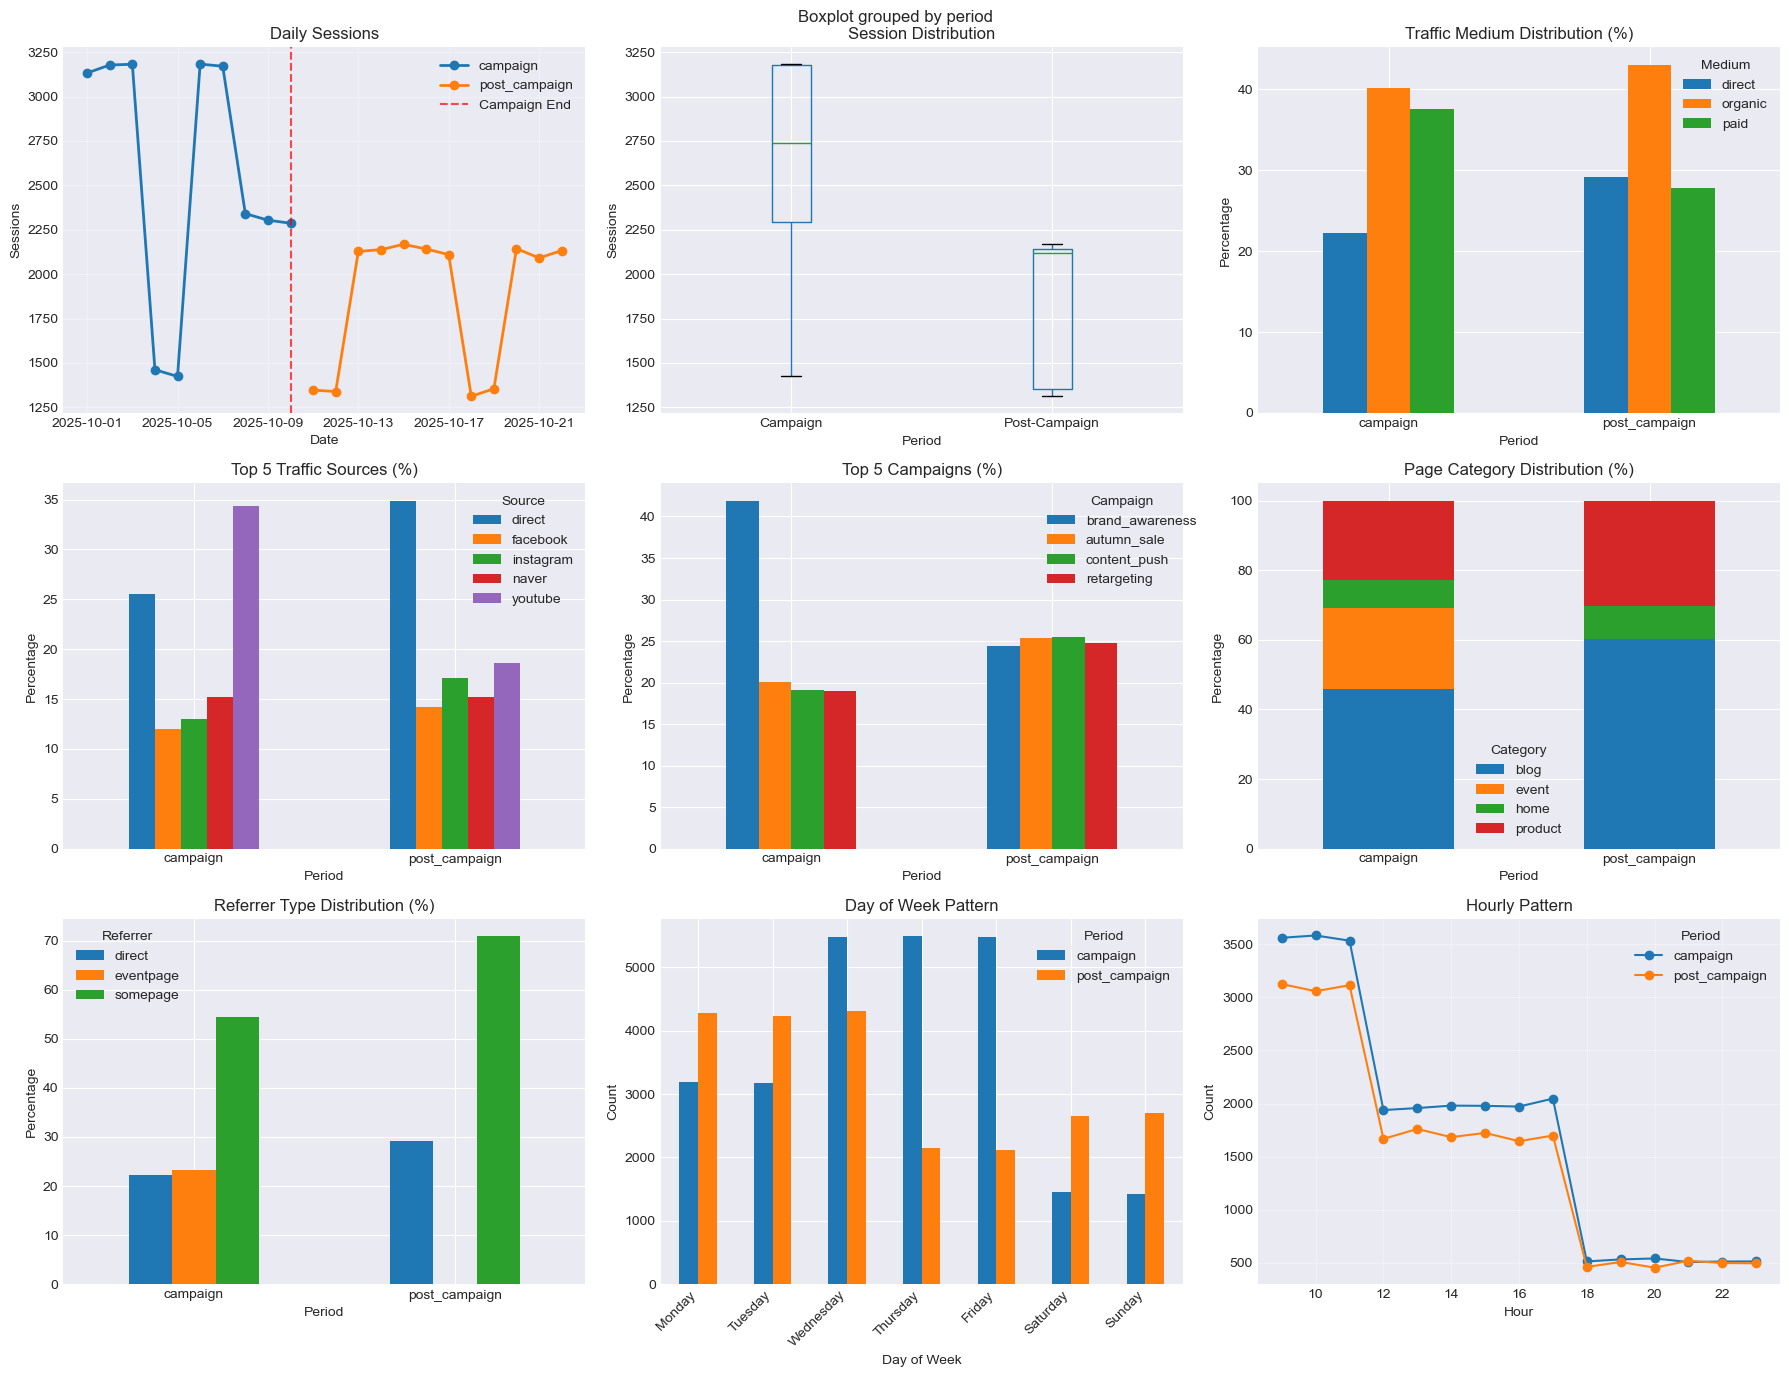

In [17]:
# 시각화
with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle('Campaign Effect Analysis: Campaign vs Post-Campaign', fontsize=16, fontweight='bold')

    # 1. 일별 세션 수
    ax1 = axes[0, 0]
    daily_pivot = daily_sessions.pivot(index='date', columns='period', values='sessions')
    daily_pivot.plot(ax=ax1, marker='o', linewidth=2)
    ax1.axvline(x=date(2025, 10, 10), color='red', linestyle='--', alpha=0.7, label='Campaign End')
    ax1.set_title('Daily Sessions')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sessions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Box plot (세션 분포)
    ax2 = axes[0, 1]
    daily_sessions.boxplot(column='sessions', by='period', ax=ax2)
    ax2.set_title('Session Distribution')
    ax2.set_xlabel('Period')
    ax2.set_ylabel('Sessions')
    plt.sca(ax2)
    plt.xticks([1, 2], ['Campaign', 'Post-Campaign'])

    # 3. utm_medium 비교
    ax3 = axes[0, 2]
    medium_pct = pd.crosstab(df['period'], df['utm_medium'], normalize='index') * 100
    medium_pct.plot(kind='bar', ax=ax3, stacked=False)
    ax3.set_title('Traffic Medium Distribution (%)')
    ax3.set_xlabel('Period')
    ax3.set_ylabel('Percentage')
    ax3.legend(title='Medium')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

    # 4. utm_source 비교 (상위 5개)
    ax4 = axes[1, 0]
    top_sources = df['utm_source'].value_counts().head(5).index
    source_pct = pd.crosstab(df[df['utm_source'].isin(top_sources)]['period'], 
                            df[df['utm_source'].isin(top_sources)]['utm_source'], 
                            normalize='index') * 100
    source_pct.plot(kind='bar', ax=ax4)
    ax4.set_title('Top 5 Traffic Sources (%)')
    ax4.set_xlabel('Period')
    ax4.set_ylabel('Percentage')
    ax4.legend(title='Source')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

    # 5. utm_campaign 비교
    ax5 = axes[1, 1]
    campaign_pct = pd.crosstab(df['period'], df['utm_campaign'], normalize='index') * 100
    top_campaigns = campaign_pct.sum().nlargest(5).index
    campaign_pct[top_campaigns].plot(kind='bar', ax=ax5)
    ax5.set_title('Top 5 Campaigns (%)')
    ax5.set_xlabel('Period')
    ax5.set_ylabel('Percentage')
    ax5.legend(title='Campaign', bbox_to_anchor=(1.05, 1))
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=0)

    # 6. path_category 비교
    ax6 = axes[1, 2]
    path_pct = pd.crosstab(df['period'], df['path_category'], normalize='index') * 100
    path_pct.plot(kind='bar', ax=ax6, stacked=True)
    ax6.set_title('Page Category Distribution (%)')
    ax6.set_xlabel('Period')
    ax6.set_ylabel('Percentage')
    ax6.legend(title='Category')
    plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0)

    # 7. referrer_type 비교
    ax7 = axes[2, 0]
    ref_pct = pd.crosstab(df['period'], df['referrer_type'], normalize='index') * 100
    ref_pct.plot(kind='bar', ax=ax7)
    ax7.set_title('Referrer Type Distribution (%)')
    ax7.set_xlabel('Period')
    ax7.set_ylabel('Percentage')
    ax7.legend(title='Referrer')
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=0)

    # 8. 요일별 패턴
    ax8 = axes[2, 1]
    dow_sessions = df.groupby(['period', 'dayofweek']).size().unstack(level=0)
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_sessions = dow_sessions.reindex(dow_order)
    dow_sessions.plot(kind='bar', ax=ax8)
    ax8.set_title('Day of Week Pattern')
    ax8.set_xlabel('Day of Week')
    ax8.set_ylabel('Count')
    ax8.legend(title='Period')
    plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 9. 시간대별 패턴
    ax9 = axes[2, 2]
    hour_sessions = df.groupby(['period', 'hour']).size().unstack(level=0)
    hour_sessions.plot(ax=ax9, marker='o')
    ax9.set_title('Hourly Pattern')
    ax9.set_xlabel('Hour')
    ax9.set_ylabel('Count')
    ax9.legend(title='Period')
    ax9.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### 통계검정
`campaign`, `post campaign`간의 변화가 뚜렷한지 확인합니다.  
 3번째 그림의 `utm_medium`의 direct, organic 증가가 유효한 지를 보는게 목표이므로 두 집단, 3가지 category변수를 다루기에 적합한 카이제곱 검정을 사용합니다.

In [18]:
# 카이제곱 검정: utm_medium 전체 분포
print("="*60)
print("카이제곱 검정: utm_medium 분포 변화")
print("="*60)

medium_table = pd.crosstab(df['period'], df['utm_medium'])
print("\n[분포표]")
print(medium_table)

chi2, p_value, dof, _ = stats.chi2_contingency(medium_table)
print(f"\n카이제곱 통계량: {chi2:.3f}")
print(f"P-value: {p_value:.4f}")
print(f"결론: {'유의한 차이 있음 (p<0.05)' if p_value < 0.05 else '유의한 차이 없음'}")

# ============================================

def test_medium_proportion(df, medium_type):
    """utm_medium 비율 검정"""
    from statsmodels.stats.proportion import proportions_ztest
    
    print("\n" + "="*60)
    print(f"비율 검정: {medium_type.capitalize()} 트래픽 변화")
    print("="*60)
    
    campaign_data = df[df['period'] == 'campaign']
    post_data = df[df['period'] == 'post_campaign']
    
    count = np.array([
        (campaign_data['utm_medium'] == medium_type).sum(),
        (post_data['utm_medium'] == medium_type).sum()
    ])
    total = np.array([len(campaign_data), len(post_data)])
    
    print(f"\n캠페인: {count[0]}/{total[0]} = {count[0]/total[0]*100:.2f}%")
    print(f"사후: {count[1]}/{total[1]} = {count[1]/total[1]*100:.2f}%")
    
    z_stat, p_value = proportions_ztest(count, total)
    print(f"\nZ-통계량: {z_stat:.3f}")
    print(f"P-value: {p_value:.4f}")
    print(f"결론: {'유의한 차이 있음' if p_value < 0.05 else '유의한 차이 없음'}")

카이제곱 검정: utm_medium 분포 변화

[분포표]
utm_medium     direct  organic  paid
period                              
campaign         5698    10323  9657
post_campaign    6530     9650  6242

카이제곱 통계량: 595.127
P-value: 0.0000
결론: 유의한 차이 있음 (p<0.05)


In [19]:
test_medium_proportion(df, 'direct')
test_medium_proportion(df, 'organic')


비율 검정: Direct 트래픽 변화

캠페인: 5698/25678 = 22.19%
사후: 6530/22422 = 29.12%

Z-통계량: -17.420
P-value: 0.0000
결론: 유의한 차이 있음

비율 검정: Organic 트래픽 변화

캠페인: 10323/25678 = 40.20%
사후: 9650/22422 = 43.04%

Z-통계량: -6.297
P-value: 0.0000
결론: 유의한 차이 있음


**추가**  
이후를 살펴보아도 좋을 듯 하다. 

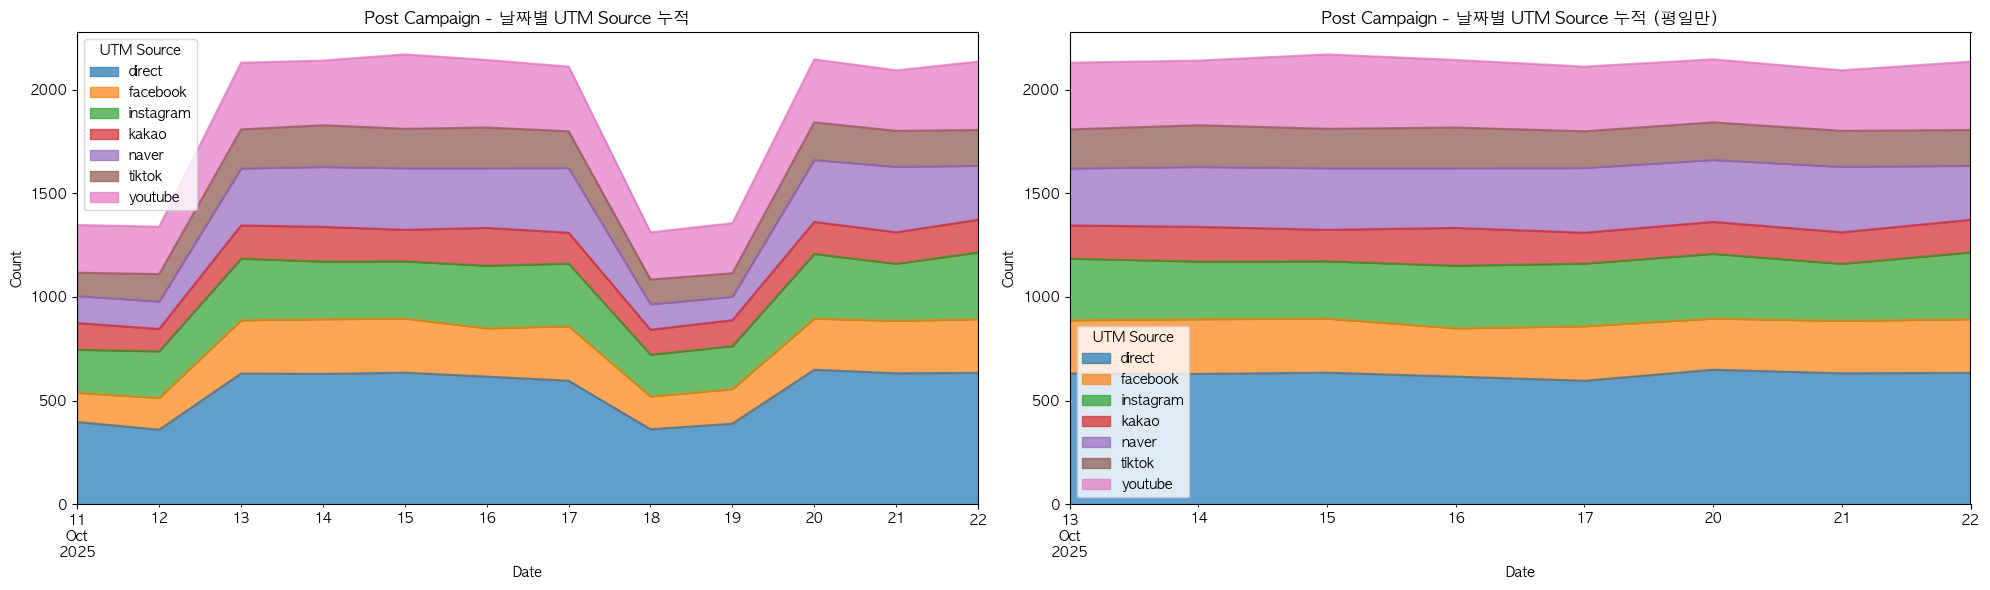

In [33]:
# 그림 생성
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# 왼쪽: 전체 데이터
post_campaign = df[df['period'] == 'post_campaign']
pivot_data = post_campaign.groupby(['date', 'utm_source']).size().unstack(fill_value=0)
pivot_data.plot(kind='area', stacked=True, alpha=0.7, ax=axes[0])
axes[0].set_title('Post Campaign - 날짜별 UTM Source 누적')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Count')
axes[0].legend(title='UTM Source')

# 오른쪽: 평일만
post_campaign_weekday = df[df['period'] == 'post_campaign'].copy()
post_campaign_weekday['dayofweek'] = post_campaign_weekday['date'].dt.dayofweek
post_campaign_weekday = post_campaign_weekday[post_campaign_weekday['dayofweek'] < 5]
pivot_data_weekday = post_campaign_weekday.groupby(['date', 'utm_source']).size().unstack(fill_value=0)
pivot_data_weekday.plot(kind='area', stacked=True, alpha=0.7, ax=axes[1])
axes[1].set_title('Post Campaign - 날짜별 UTM Source 누적 (평일만)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Count')
axes[1].legend(title='UTM Source')

plt.tight_layout()
plt.show()